# Purpose: Experimentation with Cosmic Ray Removal and difference image analysis to reduce false positives by postprocessing detections. Ultimately I used difference images for preprocessing and cosmic ray removal for postprocessing

In [1]:
import astroscrappy
import innvestigate
from keras.models import load_model
from keras.models import Model, Input
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool

import ProperImage.properimage.single_image as si
import ProperImage.properimage.single_image_psfs as sip
import ProperImage.properimage.propersubtract as ps

import ois

Using TensorFlow backend.


using numpy fft API


In [2]:
size = 80
def normalize(arr, samples=size * size // 4):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)
    return (arr - 0.5) * 2


def display_img(image):
    plt.figure()
    plt.imshow(normalize(image), cmap="gray")
    
    
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

gain = 6.2

amp_factor = 1.5

def gaussian(x, offset, std, amp):
    return amp * np.exp(-np.power(x - offset, 2.) / (2 * np.power(std, 2.)))


def gaussian_streak(width, offset, std, amp, bkg):
    dist = gaussian(np.arange(width), offset, std, amp) + bkg
    return dist

def implant_random_streak(image):

    image = np.copy(image)

    while True:
        std = stats.gamma.rvs(*params_gamma_width) * 0.05
        width = std * 10

        if random.random() < 0.7:
            length = stats.gamma.rvs(*params_gamma_length)
        else:
            length = np.random.random() * 30 + 10

        # use 2*std, which is "real" width
        if length / (std * 2) > 2 and length > 10 and width > 0:
            break

    streak = np.repeat(np.array([gaussian_streak(width, width / 2, std, 1, 0)]).T, length, axis=1)
    rotation = np.random.uniform(0, 360)
    streak = skimage.transform.rotate(streak, rotation, resize=True, order=3)

    y_len, x_len = image.shape
    y_len_streak, x_len_streak = streak.shape
    x_streak = np.random.randint(0, x_len - x_len_streak)
    y_streak = np.random.randint(0, y_len - y_len_streak)

    amp_min = np.std(image[y_streak:y_streak + y_len_streak, x_streak:x_streak + x_len_streak]) * amp_factor

    if random.random() < 0.9:
        amplitude = amp_min * (1 + abs(np.random.randn()))
    else:
        amplitude = (np.random.random() * 5) * amp_min

    streak *= amplitude

    # add shot noise
    streak = np.random.poisson(streak * gain)

    streak = streak / gain
    shape = streak.shape
    image[y_streak:y_streak + shape[0], x_streak:x_streak + shape[1]] += streak

    return image

In [3]:
filenames = glob.glob("/media/rd1/ztf_neos/training_examples/aligned/*")

In [6]:
sci, ref = np.load("/mnt/etdisk9/ztf_neos/training_examples/aligned/ztf_20180824406285_000297_zr_c13_o_q1_sciimg.resamp.fits.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/etdisk9/ztf_neos/training_examples/aligned/ztf_20180824406285_000297_zr_c13_o_q1_sciimg.resamp.fits.npy'

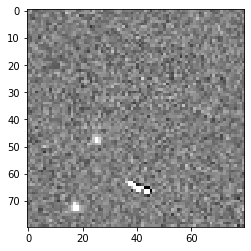

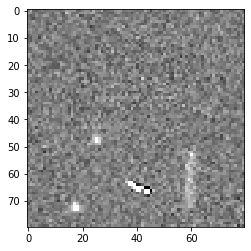

In [10]:
image = sci[2500:2580, 1100:1180]
display_img(image)
image_implant = implant_random_streak(sci[2500:2580, 1100:1180])
display_img(image_implant)

In [11]:
mask, clean = astroscrappy.detect_cosmics(image)

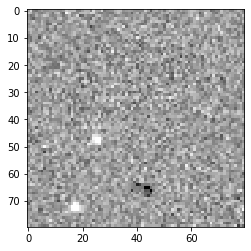

In [12]:
display_img(clean)

In [24]:
def difference(sci, ref, pi_id):

    with sip.SingleImageGaussPSF(ref, borders=False, img_id=pi_id) as ref_img, sip.SingleImageGaussPSF(sci, borders=False, img_id=pi_id) as sci_img:
        D, P, Scorr, mask = ps.diff(ref_img, sci_img, smooth_psf=False, fitted_psf=True, align=False, iterative=True, beta=True,
                                    shift=True)
        return D.real, Scorr


In [27]:
image, Scorr = difference(clean, ref[500:580, 2670:2750], 0)

found 14 sources, looking for at least 20.
                       Trying again
Sources found = 4
stamps will be 21 x 21
found 8 sources, looking for at least 20.
                       Trying again
Sources found = 2
stamps will be 15 x 15
using single psf, gaussian modeled
(2, 2, 4)
Matching result::  IDs > 0. => 2
p=2, q=2
[5.91499755 6.07510854]
('Masked pixels: ', 13)
updating stamp shape to (27,27)
('Masked pixels: ', 107)
updating stamp shape to (21,21)
Found that beta = [1.02706865 0.         0.        ]
Took only 0.00601649284362793 awesome seconds
The solution was with cost 0.0
S_corr sigma_clipped_stats 
mean = 0.0012520664361481996, median = -0.00047064767856653216, std = 0.02191332380571665

Subtraction performed in 0.286846399307251 seconds


cleaning... 
cleaning... 


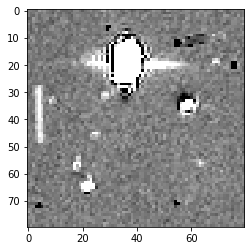

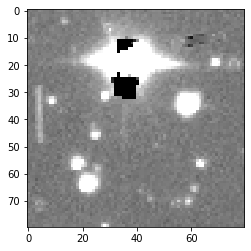

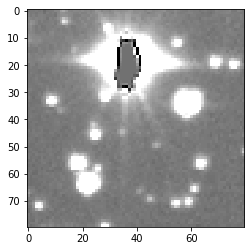

In [31]:
display_img(image)
display_img(clean)
display_img(ref[500:580, 2670:2750])

In [71]:
mask, sci_clean = astroscrappy.detect_cosmics(sci)

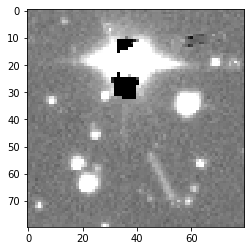

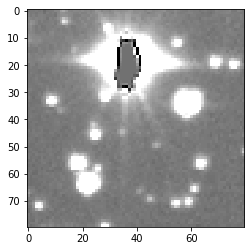

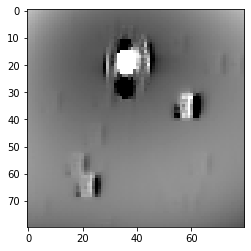

In [112]:
sci_implant = implant_random_streak(sci_clean[500:580, 2670:2750])
diff_image, optimal_image, kernel, background = ois.optimal_system(sci_implant, ref[500:580, 2670:2750], kernelshape=(7, 7), bkgdegree=3)
display_img(sci_implant)
display_img(ref[500:580, 2670:2750])
display_img(diff_image)